ME975 Satellite Data Assimilation and Analysis - Assignment 1

Jacob Currie - 201718558

Below:
**Initial setup script**, installs geemap (google maps style mapping/plotting)
Prompts earthengine authentication token
imports relevant libraries
initialises earth engine

Only needs to be run once at the start of each session!

In [ ]:
#Inital Setup
!pip install geemap
!earthengine authenticate 
import ee
import geemap.eefolium
import pprint as pp
import matplotlib.pyplot as plt
ee.Initialize()

Below:
The **Main Script** using earth engine to collect, process and store the relevant data.

It only needs to be run once to acquire and store the data for use elsewhere.

(This takes time to run, the .getInfo() method causes delay in acquiring data)

In [ ]:
#Main Script
DistrictNamesList = ['Borders', 'Central', 'Dumfries and Gal', 'Fyfe', 'Grampian', 'Highland', 'Lothian', 'Orkney', 'Shetland Islands', 'Strathclyde', 'Tayside', 'Western Isles'] #List of the level2 District Names

NO2_2019List = [] #Empty lists for storing per-district data
NO2_2020List = []
NO2_2021List = []
PopDensList = []

Scotland_Bounds = ee.FeatureCollection("FAO/GAUL/2015/level2").filterMetadata('ADM1_NAME', 'equals', 'Scotland') #Getting Scotland District Bounds
Population_Data = ee.Image("JRC/GHSL/P2016/POP_GPW_GLOBE_V1/2015").select('population_count').clip(Scotland_Bounds.geometry()) #Getting Population data
NO2_Data = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2").filterBounds(Scotland_Bounds.geometry()) #Getting total NO2 data

NO2_2019 = NO2_Data.filterDate('2019-01-01', '2019-12-31').mean().select(['tropospheric_NO2_column_number_density']).clip(Scotland_Bounds.geometry()) #Per-Year mean NO2 column density image clipped to Scotland
NO2_2020 = NO2_Data.filterDate('2020-01-01', '2020-12-31').mean().select(['tropospheric_NO2_column_number_density']).clip(Scotland_Bounds.geometry())
NO2_2021 = NO2_Data.filterDate('2021-01-01', '2021-12-31').mean().select(['tropospheric_NO2_column_number_density']).clip(Scotland_Bounds.geometry()) 

for District in DistrictNamesList: #For every district - calling .getInfo() inside loop - inefficient but it works
  District_Bounds = Scotland_Bounds.filterMetadata('ADM2_NAME', 'equals', District) #Getting level2 district data
  NO2_2019List.append(NO2_2019.reduceRegion(**{'geometry': District_Bounds.geometry(), 'reducer': ee.Reducer.mean(),'scale': 1000,}).getInfo()['tropospheric_NO2_column_number_density']) #NO2 value for each district
  NO2_2020List.append(NO2_2020.reduceRegion(**{'geometry': District_Bounds.geometry(), 'reducer': ee.Reducer.mean(),'scale': 1000,}).getInfo()['tropospheric_NO2_column_number_density']) #per-year NO2 value (reduce over region)
  NO2_2021List.append(NO2_2021.reduceRegion(**{'geometry': District_Bounds.geometry(), 'reducer': ee.Reducer.mean(),'scale': 1000,}).getInfo()['tropospheric_NO2_column_number_density'])
  PopSize = Population_Data.reduceRegion(**{'geometry': District_Bounds.geometry(), 'reducer': ee.Reducer.sum(), 'scale': 250, 'maxPixels':1e9})  #Getting total population size per district (reduce over region)
  PopDensList.append(PopSize.getInfo()['population_count']/ 1e6 / District_Bounds.aggregate_array('Shape_Area').getInfo()[0]) #Calculating population density per district {=total population / district area}

for i in range(len(DistrictNamesList)): #PRINTING RESULTS TO CONSOLE - for each district - printing NO2 and population density
  print('District: '+DistrictNamesList[i])
  print('(mol/m^2) - 2019 NO2: '+str(round(NO2_2019List[i],12))+' - 2020 NO2: '+str(round(NO2_2020List[i],12))+' - 2021 NO2: '+str(round(NO2_2021List[i],12))+' - Population Density: '+str(PopDensList[i]))
  print('---------------------')


District: Borders
(mol/m^2) - 2019 NO2: 2.2122009e-05 - 2020 NO2: 2.0716044e-05 - 2021 NO2: 2.2101361e-05 - Population Density: 0.17426138278757503
---------------------
District: Central
(mol/m^2) - 2019 NO2: 2.3609145e-05 - 2020 NO2: 2.1842954e-05 - 2021 NO2: 2.207591e-05 - Population Density: 0.7882225176754679
---------------------
District: Dumfries and Gal
(mol/m^2) - 2019 NO2: 2.2920206e-05 - 2020 NO2: 2.0838283e-05 - 2021 NO2: 2.0215836e-05 - Population Density: 0.1657262549941687
---------------------
District: Fyfe
(mol/m^2) - 2019 NO2: 2.9965724e-05 - 2020 NO2: 2.7177963e-05 - 2021 NO2: 3.0077169e-05 - Population Density: 1.8709740668009556
---------------------
District: Grampian
(mol/m^2) - 2019 NO2: 1.7438069e-05 - 2020 NO2: 1.8644532e-05 - 2021 NO2: 1.932079e-05 - Population Density: 0.44117151972967555
---------------------
District: Highland
(mol/m^2) - 2019 NO2: 1.6123909e-05 - 2020 NO2: 1.5392865e-05 - 2021 NO2: 1.4390165e-05 - Population Density: 0.05845195977637799

Below: The **Mapping Script** that produces the Geemap (Google maps style) figures, each different set of data (year selection, NO2, population size, etc.) are represented as different layers on the map that can be shown and hidden from the layer menu.

In [ ]:
#Geemap Mapping Script

#plotting options
NO2_viz = {'min': 0, 'max': 0.00008, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}
Pop_viz = {'min': 0, 'max': 50, 'palette': ['white', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

#Making Geemap + layers
Map = geemap.Map(center=[57.404790, -4.304002], zoom=6)
Map.addLayer(Population_Data, Pop_viz, 'Population')
Map.addLayer(NO2_2019, NO2_viz, 'NO2 2019')
Map.addLayer(NO2_2020, NO2_viz, 'NO2 2020')
Map.addLayer(NO2_2021, NO2_viz, 'NO2 2021')
Map.addLayer(Scotland_Bounds, {}, 'Bounds')
Map.addLayerControl()
Map

Map(center=[57.40479, -4.304002], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

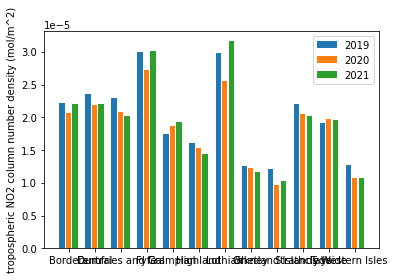

In [ ]:
#Plotting Script
import matplotlib.pyplot as plt
import numpy as np

DistrictNamesList = ['Borders', 'Central', 'Dumfries and Gal', 'Fyfe', 'Grampian', 'Highland', 'Lothian', 'Orkney', 'Shetland Islands', 'Strathclyde', 'Tayside', 'Western Isles']

Data2019 = [2.2122008554262085e-05,2.3609144718329626e-05,2.2920205749643354e-05,2.996572421056435e-05,1.7438069491396237e-05,1.6123909193907615e-05,
            2.978613519760064e-05,1.2591065901324445e-05,1.2150154708114013e-05,2.2034038841374178e-05,1.916083730769428e-05,1.2717830142645274e-05]
Data2020 = [2.0716044129793837e-05,2.184295374201366e-05,2.0838283314443245e-05,2.7177963032354258e-05,1.8644532261182567e-05,1.5392865174184957e-05,
            2.5521300512970897e-05,1.227162058641417e-05,9.72305618677271e-06,2.04907429503703e-05,1.9815419902427874e-05,1.0717729418158482e-05]
Data2021 = [2.210136053056543e-05,2.207590961163332e-05,2.0215835905095158e-05,3.0077168762210414e-05,1.9320790396829416e-05,1.439016460944674e-05,
            3.158178579266714e-05,1.1731656606566475e-05,1.0305211852537112e-05,2.0276745580832056e-05,1.9620622300899496e-05,1.0706163989725942e-05]
LegendLabels = ['2019', '2020', '2021']            
PopDensity = [0.17426138278757503,0.7882225176754679,0.1657262549941687,1.8709740668009556,0.44117151972967555,0.058451959776377994,
            3.289956581898585,0.1320787293067459,0.07400979504997422,1.0977339910833979,0.3546662688716222,0.055960752561892306]

N = len(DistrictNamesList)
xIndex = np.arange(N) * 4

def NO2_Plot(data):
    f1, ax = plt.subplots()
    for i in range(len(data)):
        ax.bar(xIndex + i, data[i])

    ax.set_xticks(xIndex + 1)
    ax.set_xticklabels(DistrictNamesList)
    ax.legend(LegendLabels)
    ax.set_ylabel('tropospheric NO2 column number density (mol/m^2)')
    
rawData = [Data2019, Data2020, Data2021]
NO2_Plot(rawData)